In [1]:
!pip install mtcnn

In [3]:
!pip install keras-facenet

In [5]:
!pip install imgaug Pillow

In [7]:
# Set dataset path and import libraries
import os
import cv2 as cv
import numpy as np
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns

2024-11-24 21:24:12.862270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
img = cv.imread("/Users/risha/Desktop/ARTIFICIAL_INTELLIGENCE/AI_PROJECT/imgs_dataset/risha_images/risha_1.jpg")

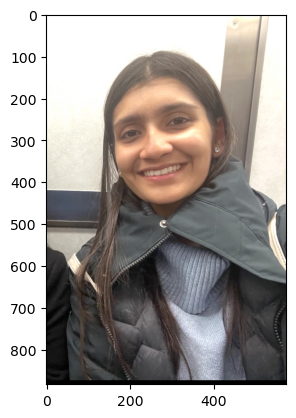

In [11]:
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)

In [13]:
np.bool = np.bool_

# Function to apply data augmentation
def augment_image(image):
    augmentations = iaa.SomeOf((1, 4), [  
        iaa.Affine(rotate=(-15, 15)),
        iaa.Affine(scale=(0.8, 1.2)),
        iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
        iaa.Multiply((0.8, 1.2)),
        iaa.Fliplr(1.0),
        iaa.GaussianBlur(sigma=(0, 1.5))
    ])
    return augmentations(image=image)

In [15]:
augmented_images = [augment_image(img) for _ in range(5)]

In [17]:
augmented_images

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [245, 245, 245],
         [248, 248, 248],
         [248, 248, 248]],
 
        [[254, 254, 254],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [245, 245, 245],
         [255, 255, 255]],
 
        [[238, 238, 238],
         [242, 242, 242],
         [254, 254, 254],
         ...,
         [250, 250, 250],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  9,   9,   9],
         ...,
         [ 16,  16,  16],
         [ 26,  26,  26],
         [  4,   4,   4]],
 
        [[  0,   0,   0],
         [ 16,  16,  16],
         [ 13,  13,  13],
         ...,
         [ 17,  17,  17],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  9,   9,   9],
         [  3,   3,   3],
         [  6,   6,   6],
         ...,
         [  0,   0,   0],
  

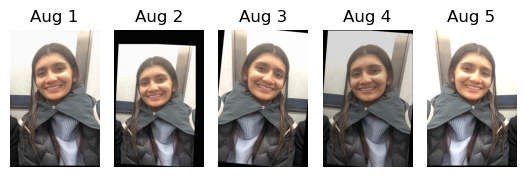

In [19]:
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug_img)
    plt.title(f"Aug {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
detector = MTCNN()

In [23]:
def alignFace(img, keypoints):
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx)) 

    eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

    rot_matrix = cv.getRotationMatrix2D(eyes_center, angle, 1)

    aligned_face = cv.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return aligned_face

In [25]:
aligned_faces = []
results_list = []
for i, aug_img in enumerate(augmented_images):
    result = detector.detect_faces(aug_img)
    results_list.append(result)

    if result:  
        aligned_face = alignFace(aug_img, result[0]['keypoints'])
        aligned_faces.append(aligned_face)
    else:
        print(f"No face detected in augmented image {i}")


print(f"Aligned {len(aligned_faces)} faces from augmented images.")

Aligned 5 faces from augmented images.


In [27]:
results_list

[[{'box': [144, 154, 248, 284],
   'confidence': 0.9999340772628784,
   'keypoints': {'nose': [259, 326],
    'mouth_right': [337, 352],
    'right_eye': [314, 255],
    'left_eye': [206, 280],
    'mouth_left': [221, 377]}}],
 [{'box': [145, 232, 222, 257],
   'confidence': 0.9999735355377197,
   'keypoints': {'nose': [247, 387],
    'mouth_right': [317, 410],
    'right_eye': [296, 323],
    'left_eye': [199, 342],
    'mouth_left': [209, 428]}}],
 [{'box': [181, 152, 247, 297],
   'confidence': 0.9999972581863403,
   'keypoints': {'nose': [327, 330],
    'mouth_right': [354, 387],
    'right_eye': [387, 295],
    'left_eye': [278, 257],
    'mouth_left': [245, 349]}}],
 [{'box': [155, 165, 245, 288],
   'confidence': 0.999994158744812,
   'keypoints': {'nose': [267, 336],
    'mouth_right': [344, 368],
    'right_eye': [326, 269],
    'left_eye': [216, 287],
    'mouth_left': [225, 383]}}],
 [{'box': [170, 152, 243, 296],
   'confidence': 0.9999996423721313,
   'keypoints': {'nose':

In [29]:
print(results_list[0])

[{'box': [144, 154, 248, 284], 'confidence': 0.9999340772628784, 'keypoints': {'nose': [259, 326], 'mouth_right': [337, 352], 'right_eye': [314, 255], 'left_eye': [206, 280], 'mouth_left': [221, 377]}}]


In [31]:
x,y,w,h = result[0]['box']

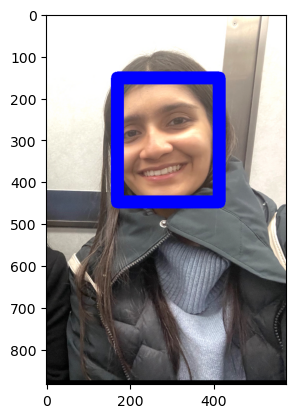

In [33]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255),30)
plt.imshow(img)

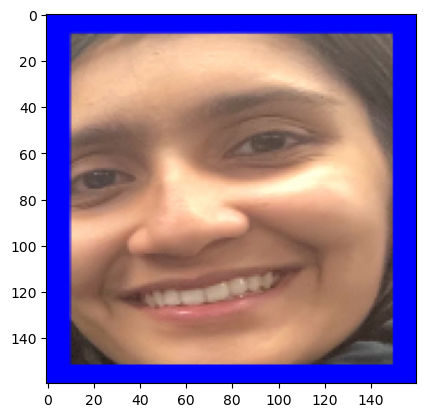

In [35]:
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [37]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

In [39]:
dataset_path = "/Users/risha/Desktop/ARTIFICIAL_INTELLIGENCE/AI_PROJECT/imgs_dataset"

class FaceLoading:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

        
        self.augmenter = iaa.Sequential([
            iaa.Fliplr(0.5),  # Horizontal flip
            iaa.GaussianBlur(sigma=(0, 0.5)), 
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  
            iaa.Multiply((0.8, 1.2)),  # Change brightness
            iaa.Affine(rotate=(-15, 15)),
        ])

    def alignFace(self, img, keypoints):
        left_eye = keypoints['left_eye']
        right_eye = keypoints['right_eye']
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))
        eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
        rot_matrix = cv.getRotationMatrix2D(eyes_center, angle, 1)
        aligned_face = cv.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))
        return aligned_face

    def extractFace(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.detector.detect_faces(img)
        if not results:
            raise Exception("No face detected in the original image")
        keypoints = results[0]['keypoints']
        aligned_img = self.alignFace(img, keypoints)
        new_results = self.detector.detect_faces(aligned_img)
        if not new_results:
            raise Exception("No face detected after alignment")
        x, y, w, h = new_results[0]['box']
        x, y = abs(x), abs(y)
        face = aligned_img[y:y + h, x:x + w]
        face_array = cv.resize(face, self.target_size)
        return face_array

    def loadFace(self, dir):
        faces = []
        for img_name in os.listdir(dir):
            try:
                if img_name.startswith('.'):
                    continue
                path = dir + img_name
                indiv_face = self.extractFace(path)

                # Apply augmentation
                aug_faces = self.augmenter.augment_images([indiv_face] * 3)  # Create 3 augmented variations
                faces.extend(aug_faces) 
                faces.append(indiv_face)
            except Exception as e:
                pass
        return faces

    def loadClasses(self):
        for sub_dir in os.listdir(self.directory):
            # path = os.path.join(self.directory, sub_dir)
            path = self.directory +'/'+ sub_dir+'/'
            if not os.path.isdir(path): 
                continue
            faces = self.loadFace(path)
            labels = [sub_dir for _ in range(len(faces))]
            print(f"Successfully loaded: {len(labels)} faces for class '{sub_dir}'")
            self.X.extend(faces)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)

    def plotImages(self):
        for num, image in enumerate(self.X):
            ncols = 10
            nrows = len(self.Y) // ncols + 1
            # plt.figure(figsize=(8, nrows * 1))
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')


In [41]:
faceloading = FaceLoading(dataset_path)
X, Y = faceloading.loadClasses()

Successfully loaded: 40 faces for class 'suhrad_images'
Successfully loaded: 40 faces for class 'risha_images'
Successfully loaded: 40 faces for class 'Jay_Patel'
Successfully loaded: 40 faces for class 'aayushee_images'
Successfully loaded: 40 faces for class 'Krupa_Lakhani'
Successfully loaded: 40 faces for class 'Het_Patel'


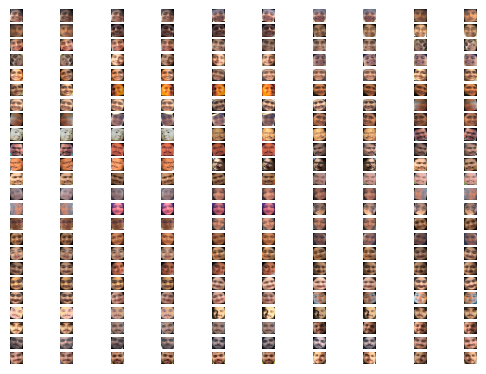

In [43]:
faceloading.plotImages()

In [45]:
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    embedding = embedder.embeddings(face_img)
    return embedding[0]

In [47]:
X

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

In [49]:
embd_X = []

for img in X:
    # embd_X.append(get_embedding(img))
    resized_img = cv.resize(img, (160, 160))
    embd_X.append(get_embedding(resized_img))

embd_X = np.asarray(embd_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [51]:
np.savez_compressed('faces_embeddings_done_tl.npz', embd_X, Y)

In [53]:
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [55]:
Y

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Text(0, 0.5, '5')

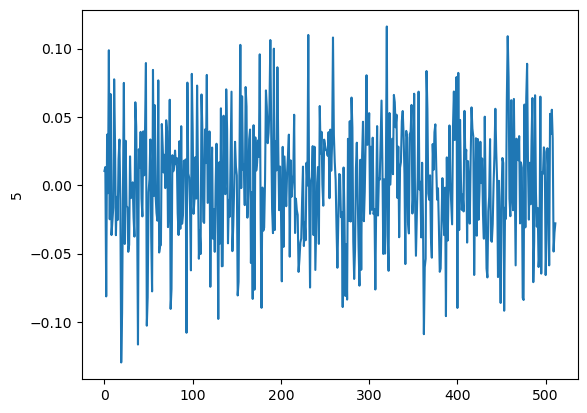

In [57]:
plt.plot(embd_X[0])
plt.ylabel(Y[0])

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(embd_X, Y, shuffle=True, random_state=17)

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'class_weight': ['balanced', None]
}

In [67]:
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [69]:
grid_search.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [71]:
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


In [73]:
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

In [75]:
y_pred_proba = best_model.predict_proba(X_test_scaled)

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train_accuracy = accuracy_score(Y_train, y_pred_train)
test_accuracy = accuracy_score(Y_test, y_pred_test)

train_recall = recall_score(Y_train, y_pred_train, average='weighted')
test_recall = recall_score(Y_test, y_pred_test, average='weighted')

train_f1 = f1_score(Y_train, y_pred_train, average='weighted')
test_f1 = f1_score(Y_test, y_pred_test, average='weighted')

# Calculate and print ROC AUC if probabilities are provided
if y_pred_proba is not None:
    roc_auc = roc_auc_score(Y_test, y_pred_proba, multi_class='ovr')
    # print(f"ROC AUC: {roc_auc}")

print("Training Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

print("Test Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC: {roc_auc}")




Training Metrics:
Accuracy: 0.5922222222222222
Recall: 0.5922222222222222
F1 Score: 0.47060558188520274
Test Metrics:
Accuracy: 0.57
Recall: 0.57
F1 Score: 0.4591304347826087
ROC AUC: 0.5


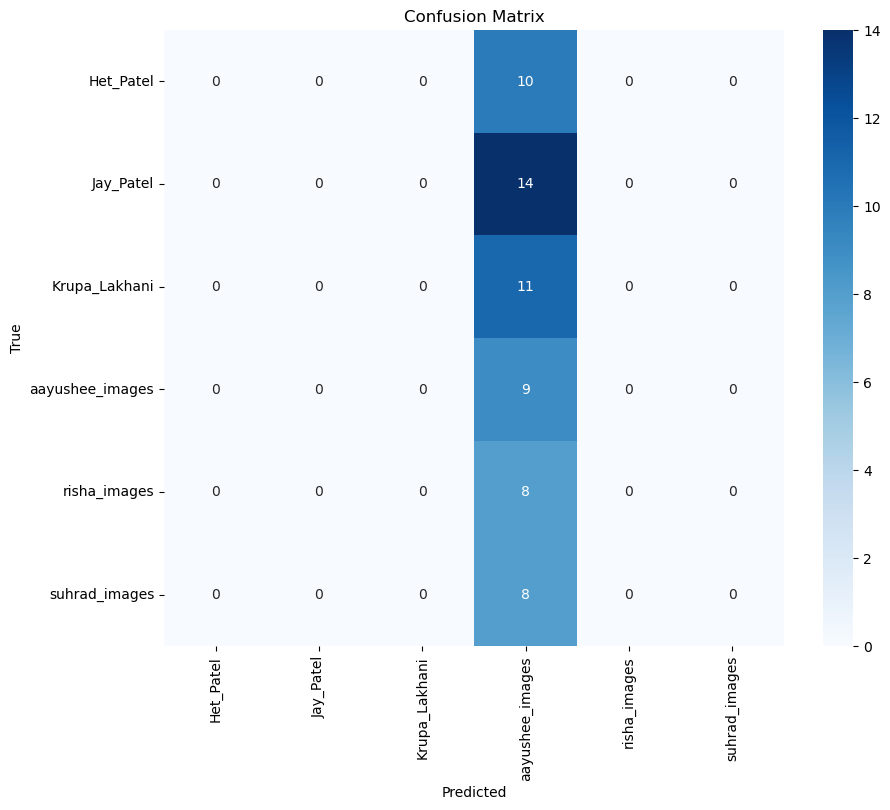

In [111]:
class_labels = encoder.classes_
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [131]:
test_img = cv.imread("/Users/risha/Downloads/risha_test_1.jpg")
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(test_img)[0]['box']

In [133]:
test_img = test_img[y:y+h, x:x+w]
test_img = cv.resize(test_img, (160,160))
t_img = get_embedding(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [135]:
t_img = [t_img]
t_img

[array([ 0.01040817,  0.01323743, -0.08136161,  0.03703693, -0.00583532,
         0.09873085, -0.02493108,  0.06667081, -0.03646994, -0.02634571,
        -0.01645712,  0.07746426,  0.02978943, -0.03657426, -0.00851209,
        -0.02543745,  0.01909425,  0.03340081, -0.01135213, -0.12970874,
        -0.09350712, -0.00186395,  0.07484038, -0.0429936 ,  0.03251211,
        -0.01524375, -0.0160828 , -0.04873962, -0.04360047,  0.02108771,
        -0.00943478, -0.00025411,  0.00208789, -0.02367698, -0.03761333,
         0.06066556,  0.04307506, -0.01791338, -0.11657034,  0.02633477,
         0.01289767,  0.0389986 , -0.00975662, -0.02284096,  0.03940051,
         0.0072353 ,  0.03982001,  0.08939081, -0.10278586, -0.0819013 ,
        -0.0051559 ,  0.00425588,  0.03345906, -0.0378776 , -0.07769362,
         0.08435165, -0.00782712,  0.05853546, -0.00762564, -0.02032345,
        -0.02597619,  0.07670612, -0.0492494 , -0.04457959, -0.04377818,
         0.04477919,  0.02838226,  0.00930388,  0.0

In [137]:
ypreds = best_model.predict(t_img)

In [139]:
ypreds

array([3])

In [141]:
encoder.inverse_transform(ypreds)

array(['aayushee_images'], dtype='<U15')